# Estimation of factor sensitivities

## Data generation

We create a 3 factor model for a return time series. We will take the sensitivities to the factors to be time dependent, with the following shapes:
- A random smooth stationary series.
- A smooth increase, then decrease.
- A step function from 0 to 1. 
The factors themselves will be stationary time series. For now we take them to be random white noise. We could also take them to be smooth functions. In addition there is idiosynchratic component to the returns, which is a white noise too.

## Making the study rigorous

We need to:
- Rewrite the whole code in the form of a unique function that creates the samples, performes the rolling regression and Kalman estimations, and returns all the performance metrics.
- Then we should run this function a lot of times to gather statistics on the performance.
- We should think carefully about what kind of statistical test we can make to decide whether the performance of one method is significantly superior.
- We could add more factor shapes.
- We could use non-gaussian noise.
- We could vary the intensity of the noise (but this will require to reestimate the windo of the rolling regression and the covariances of the Kalman filters.


In [785]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from pyfinance.ols import OLS, RollingOLS, PandasRollingOLS
import pykalman
from pykalman import KalmanFilter
from scipy.interpolate import splrep, splev



In [786]:
# Sensitivity type
sens_type = "Random smooth" # "Random walk" # "Various smooth" #c

In [787]:
# Strategy parameters
if sens_type == "Random walk":
    # Rolling window for ols regression
    rolling_ols_window = 400
    # Lambda parameter for exponentially weighted ols regression
    exp_rolling_ols_lambda = 0.005
    # Transition covariance/observatiaion covariance for the Kalman filter 
    kalman_covariance_ratio = 0.00002
    # "Momentum" for the naive trend Kalman filter
    nt_factor = 0.5
    # Rolling window over which to compute the momentum
    nt_window = 100
    # Transition covariance/observation covariance for the stochastic trend Kalman filter.
    stkf_covariance_ratio = 2e-10
elif sens_type == "Various smooth" or sens_type == "Random smooth":
    rolling_ols_window = 200
    exp_rolling_ols_lambda = 0.01
    kalman_covariance_ratio = 0.0001
    stkf_covariance_ratio = 1e-9
    nt_factor = 0.5
    nt_window = 100    

In [788]:
# Helper functions
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
performance_record_mse = {}
performance_record_wacc = {}

def create_random_sensitivity(timespan):
    num_points = int(np.round(np.random.rand()*8) + 2)
    smoothing_parameter = np.exp(2*np.random.rand() - 1.5)
    x = np.floor(np.random.rand(num_points)*timespan)
    x = np.append(x, [0, timespan-1])
    x.sort()
    y = 2*np.random.rand(num_points + 2) - 1

    spleen = splrep(x, y, s=smoothing_parameter)
    values = splev(factors.index, spleen)
    sensitivity = pd.Series(data=values, index=factors.index)
    sensitivity[sensitivity < -5] = -5
    sensitivity[sensitivity > 5] = 5
    return sensitivity

def plot_estimated_sensitivities(sens, est_sens, colors):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    axc = ax[0,0]
    axc.plot(est_sens.iloc[:,0], c=colors[0])
    axc.plot(sens.iloc[:,0], '--', c='k')
    axc = ax[0,1]
    axc.plot(est_sens.iloc[:,1], c=colors[1])
    axc.plot(sens.iloc[:,1], '--', c='k')
    axc = ax[1,0]
    axc.plot(est_sens.iloc[:,2], c=colors[2])
    axc.plot(sens.iloc[:,2], '--', c='k')
    
def compute_estimated_returns(factors, est_sens):
    return pd.Series(np.multiply(factors, est_sens.shift()).sum(axis=1))

def plot_residuals(estimated_returns, returns):
    residuals = estimated_returns - returns
    plt.scatter(residuals.index, residuals, s=0.5)
    
def print_mse_performance(estimated_returns, returns, name, performance_record_mse, verbose=True):
    square_errors = np.square(estimated_returns - returns)
    mean_square_error = square_errors.sum()/len(estimated_returns)
    performance_record_mse[name] = mean_square_error
    if verbose:
        print(f"MSE for {name}, assuming the factors known: {mean_square_error}")
    
def print_weighted_accuracy_performance(estimated_returns, returns, name, performance_record_wacc, verbose=True):
    weights = abs(returns)
    correct_sign = -2*np.logical_xor(estimated_returns > 0, returns > 0) + 1
    weighted_accuracy = np.multiply(weights, correct_sign).mean()
    performance_record_wacc[name] = weighted_accuracy
    if verbose:
        print(f"Weighted accuracy for {name}, assuming the factors known: {weighted_accuracy}")
    
def plot_prediction_performance(factors, returns, est_sens, name):
    estimated_returns = compute_estimated_returns(factors, est_sens)
    print_mse_performance(estimated_returns, returns, name, performance_record_mse)
    print_weighted_accuracy_performance(estimated_returns, returns, name, performance_record_wacc)
    plot_residuals(estimated_returns, returns)
    

In [789]:
# Sensitivities
timespan = 10000
pi = 3.1415
t = np.linspace(0,timespan-1,timespan,dtype=np.float64)
if sens_type == "Various smooth":
    sens1 = -(pd.Series(np.arctan((t-timespan/2)/timespan*100)) - pi/2)/pi
    sens2 = (pd.Series(np.sin(t/timespan*3.2 - 1.5)) + 1)/2
    sens3 = pd.Series(np.sin(t/timespan*5) + np.sin(t/timespan*10 + 150) + \
                      np.sin(t/timespan*20 + 150))/2
elif sens_type == "Random walk":
    sens1 = pd.Series(np.random.normal(size=timespan)).cumsum()/200 + 1
    sens2 = pd.Series(np.random.normal(size=timespan)).cumsum()/200
    sens3 = pd.Series(np.random.normal(size=timespan)).cumsum()/200 - 1
elif sens_type == "Random smooth":
    sens1 = create_random_sensitivity(timespan)
    sens2 = create_random_sensitivity(timespan)
    sens3 = create_random_sensitivity(timespan)

sens = pd.concat([sens1, sens2, sens3], axis=1)

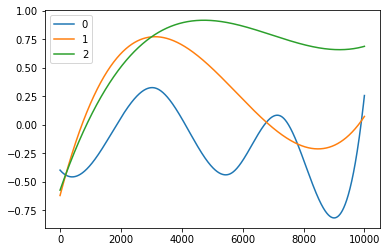

In [790]:
sens.plot()

In [791]:
# Factors
factor1 = pd.Series(np.random.normal(size=timespan))
factor2 = pd.Series(np.random.normal(size=timespan))
factor3 = pd.Series(np.random.normal(size=timespan))
factors = pd.concat([factor1, factor2, factor3], axis=1)

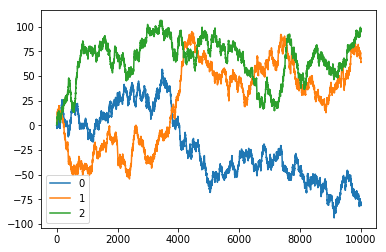

In [792]:
factors.cumsum(axis=0).plot()

In [793]:
# Returns
error = np.random.normal(size=timespan)*1.0
returns = pd.Series(np.multiply(factors, sens).sum(axis=1) + error)

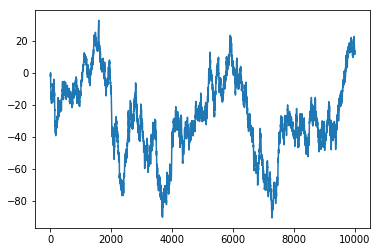

In [794]:
returns.cumsum().plot()

## Constant regression

In [795]:
def estimate_sensitivities_cr(factors, returns):
    reg = linear_model.LinearRegression()
    reg.fit(factors, returns)
    return pd.DataFrame(data = [reg.coef_], index = factors.index)

In [796]:
estimated_sensitivities_cr = estimate_sensitivities_cr(factors, returns)
estimated_sensitivities_cr

,0,1,2
0,-0.191171,0.239968,0.649816
1,-0.191171,0.239968,0.649816
2,-0.191171,0.239968,0.649816
3,-0.191171,0.239968,0.649816
4,-0.191171,0.239968,0.649816
5,-0.191171,0.239968,0.649816
6,-0.191171,0.239968,0.649816
7,-0.191171,0.239968,0.649816
8,-0.191171,0.239968,0.649816
9,-0.191171,0.239968,0.649816


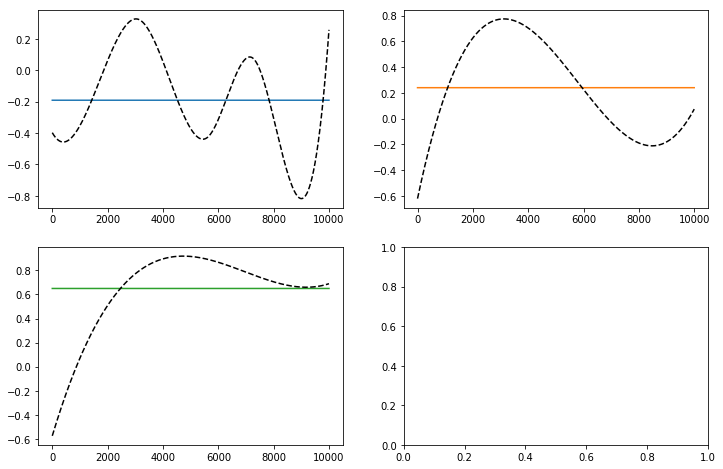

In [797]:
plot_estimated_sensitivities(sens, estimated_sensitivities_cr, colors)

MSE for Constant OLS, assuming the factors known: 1.3763829496704092
Weighted accuracy for Constant OLS, assuming the factors known: 0.5776620501086981


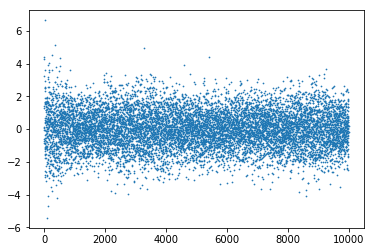

In [798]:
plot_prediction_performance(factors, 
                            returns, 
                            estimated_sensitivities_cr, 
                            "Constant OLS")

## Rolling regression

In [799]:
def estimate_sensitivities_rr(factors, returns, window):
    model = PandasRollingOLS(y=returns, x=factors, window=window)
    return pd.DataFrame(model.beta)

In [800]:
window = rolling_ols_window
estimated_sensitivities_rr = estimate_sensitivities_rr(factors, returns, window)
estimated_sensitivities_rr

,0,1,2
199,-0.452601,-0.425334,-0.584530
200,-0.451773,-0.423571,-0.583344
201,-0.450947,-0.432041,-0.570725
202,-0.452470,-0.430680,-0.573680
203,-0.447948,-0.430609,-0.572622
204,-0.447223,-0.435521,-0.572825
205,-0.462553,-0.425388,-0.581559
206,-0.466986,-0.410993,-0.578742
207,-0.476793,-0.416374,-0.577334
208,-0.477506,-0.420000,-0.577498


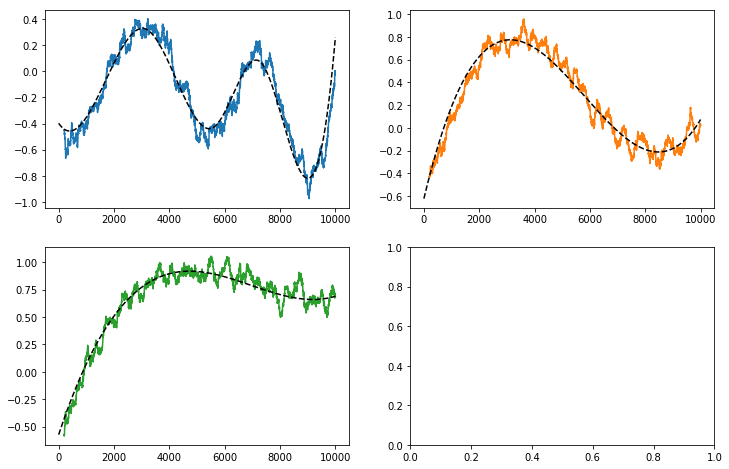

In [801]:
plot_estimated_sensitivities(sens, estimated_sensitivities_rr, colors)

MSE for Rolling OLS, assuming the factors known: 1.0203210334796888
Weighted accuracy for Rolling OLS, assuming the factors known: 0.7362277496287992


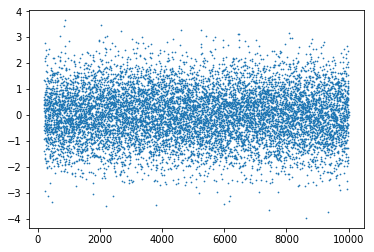

In [802]:
plot_prediction_performance(factors.iloc[window-1:,:], 
                            returns.iloc[window-1:], 
                            estimated_sensitivities_rr, 
                            "Rolling OLS")

## Weighted rolling regression

In [803]:
# How to do that efficiently??

In [804]:
def estimate_sensitivities_err(factors, returns, lambd):
    ff = np.zeros([3,3])
    fr = np.zeros(3)
    est_sens_list = []
    for i, row in factors.iterrows():
        ff = (1-lambd)*ff + lambd*np.outer(row, row)
        fr = (1-lambd)*fr + lambd*np.dot(row, returns.iloc[i])
        est_sens = np.dot(np.linalg.inv(ff + 1e-9*np.eye(3)), fr)
        est_sens_list.append(est_sens)
    return pd.DataFrame(est_sens_list)  

In [805]:
estimated_sensitivities_err = estimate_sensitivities_err(factors, returns, exp_rolling_ols_lambda)

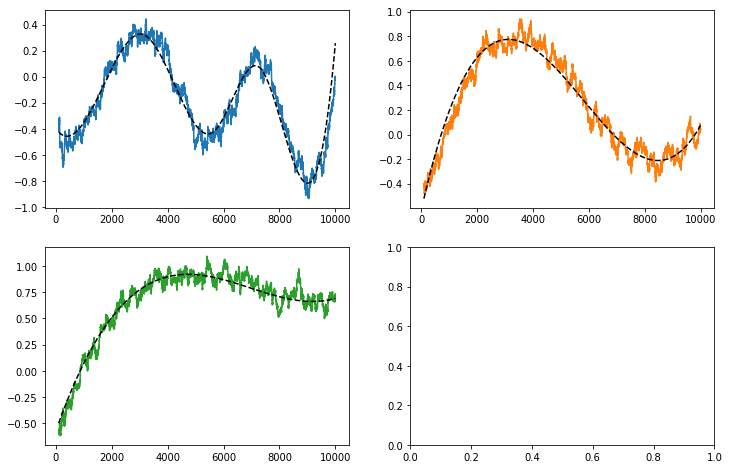

In [806]:
plot_estimated_sensitivities(sens.iloc[100:,:], estimated_sensitivities_err.iloc[100:,:], colors)

MSE for Exponential rolling OLS, assuming the factors known: 1.019195170582463
Weighted accuracy for Exponential rolling OLS, assuming the factors known: 0.7414079505740012


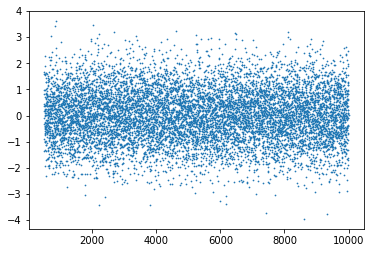

In [807]:
burn_period = 500
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_err.iloc[burn_period:,:], 
                            "Exponential rolling OLS")

## Kalman filter

In [808]:
def estimate_sensitivities_kf(factors, returns, covariance_ratio):
    n_dim_state=3
    n_dim_obs=1
    observation_covariance = 1
    transition_covariance = np.eye(3)*covariance_ratio
    observation_matrices = factors.values[:,np.newaxis,:]
    kf = KalmanFilter(initial_state_mean=[0,0,0], 
                      n_dim_state=n_dim_state, 
                      n_dim_obs=n_dim_obs, 
                      observation_matrices=observation_matrices,
                      observation_covariance=observation_covariance,
                      transition_covariance=transition_covariance
                     )
    filtered_state_means, filtered_state_covariances = kf.filter(returns)
    return pd.DataFrame(filtered_state_means)

In [809]:
covariance_ratio = kalman_covariance_ratio
estimated_sensitivities_kf = estimate_sensitivities_kf(factors, returns, covariance_ratio)
estimated_sensitivities_kf

,0,1,2
0,0.020172,-0.442422,-0.122984
1,0.006793,-0.313678,-0.580076
2,0.144503,-0.418636,-0.188035
3,-0.370137,-0.410841,-0.198773
4,-0.389725,-0.411364,-0.194663
5,-0.455806,-0.496400,-0.063249
6,-0.334262,-0.701509,-0.231773
7,-0.361755,-0.715409,-0.189670
8,-0.281288,-0.623568,-0.191633
9,-0.491965,-0.771869,-0.298792


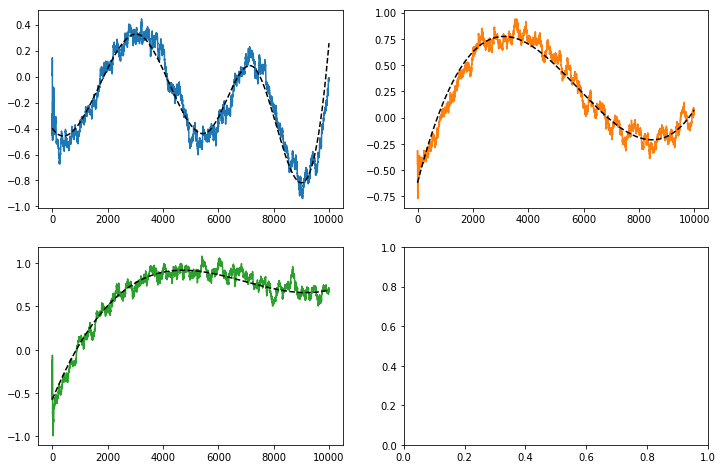

In [810]:
plot_estimated_sensitivities(sens, estimated_sensitivities_kf, colors)

MSE for Kalman, assuming the factors known: 1.0190457039151084
Weighted accuracy for Kalman, assuming the factors known: 0.7411272535632332


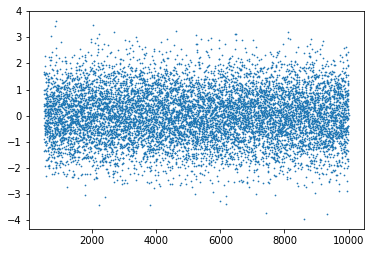

In [811]:
burn_period = 500
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_kf.iloc[burn_period:,:], 
                            "Kalman")

In [812]:
def estimate_sensitivities_ntc(estimated_sensitivities, trend_factor, window):
    rolling_mean = estimated_sensitivities.rolling(window, axis=0).mean()
    return (1 + trend_factor)*pd.DataFrame(estimated_sensitivities) - trend_factor*rolling_mean

In [813]:
# Naive trend correction...
trend_factor = .5
window = 100
estimated_sensitivities_kf_ntc = estimate_sensitivities_ntc(estimated_sensitivities_kf, trend_factor, window)
estimated_sensitivities_kf_ntc
#rolling_mean = pd.DataFrame(filtered_state_means).rolling(100, axis=0).mean()
#trend_est_sens = (1 + trend_factor)*pd.DataFrame(filtered_state_means) - trend_factor*rolling_mean

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


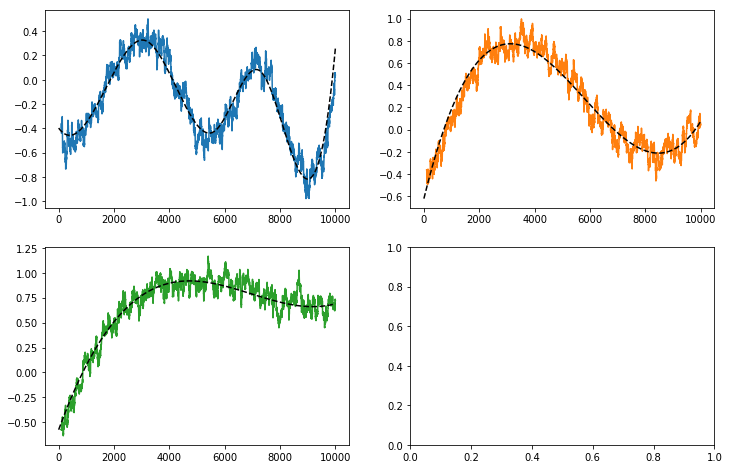

In [814]:
plot_estimated_sensitivities(sens, estimated_sensitivities_kf_ntc, colors)

MSE for Kalman naive trend, assuming the factors known: 1.024340549517264
Weighted accuracy for Kalman naive trend, assuming the factors known: 0.7403242423797118


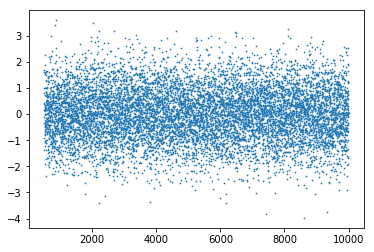

In [815]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], returns.iloc[burn_period:], estimated_sensitivities_kf_ntc.iloc[burn_period:,:], "Kalman naive trend")

## Stochastic trend Kalman filter

In [816]:
def estimate_sensitivities_stkf(factors, returns, covariance_ratio):
    n_dim_state=6
    n_dim_obs=1
    observation_covariance = 1
    transition_covariance = covariance_ratio*np.eye(6)
    observation_matrices = np.array([factors.values[:, 0], 0*factors.values[:, 0],
                                     factors.values[:, 1], 0*factors.values[:, 1],
                                     factors.values[:, 2], 0*factors.values[:, 2]]).transpose()[:, np.newaxis,:]
    transition_matrix = np.kron(np.eye(3), np.array([[1, 1], [0, 1]]))
    kf = KalmanFilter(initial_state_mean=[0, 0, 0, 0, 0, 0], 
                      n_dim_state=n_dim_state, 
                      n_dim_obs=n_dim_obs, 
                      observation_matrices=observation_matrices,
                      observation_covariance=observation_covariance,
                      transition_covariance=transition_covariance,
                      transition_matrices=transition_matrix
                     )
    filtered_state_means, filtered_state_covariances = kf.filter(returns)
    return pd.DataFrame(filtered_state_means[:,[0,2,4]])

In [817]:
estimated_sensitivities_stkf = estimate_sensitivities_stkf(factors, returns, stkf_covariance_ratio)
estimated_sensitivities_stkf

,0,1,2
0,0.020172,-0.442422,-0.122984
1,-0.002225,-0.220984,-0.868835
2,0.438763,-0.434809,-0.126202
3,-0.625647,-0.147291,0.277064
4,-0.618083,-0.291320,0.243836
5,-0.963868,-0.815409,0.399895
6,-1.227547,-1.478974,-0.118828
7,-1.194007,-1.463916,-0.615613
8,0.030286,-0.905718,0.034258
9,-0.371989,-1.073109,-0.238730


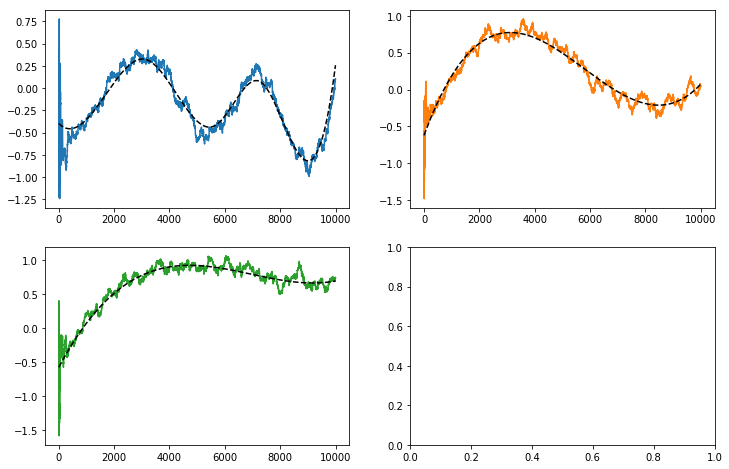

In [818]:
plot_estimated_sensitivities(sens, estimated_sensitivities_stkf, colors)

MSE for Kalman stoch trend, assuming the factors known: 1.0188279387724108
Weighted accuracy for Kalman stoch trend, assuming the factors known: 0.7454965047355585


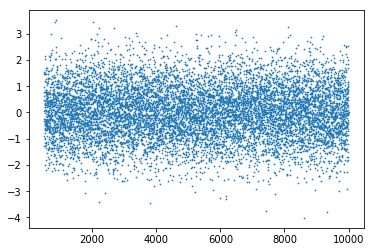

In [819]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_stkf.iloc[burn_period:,:], 
                            "Kalman stoch trend")

## Performance summary

In [820]:
pd.Series(performance_record_mse).sort_values()

Kalman stoch trend         1.018828
Kalman                     1.019046
Exponential rolling OLS    1.019195
Rolling OLS                1.020321
Kalman naive trend         1.024341
Constant OLS               1.376383
dtype: float64

In [821]:
pd.Series(performance_record_wacc).sort_values(ascending=False)

Kalman stoch trend         0.745497
Exponential rolling OLS    0.741408
Kalman                     0.741127
Kalman naive trend         0.740324
Rolling OLS                0.736228
Constant OLS               0.577662
dtype: float64

## Systematic analysis

We want to run the experiment above a large number of times to gather statistics on the performance of the regression estimators.

In [367]:
def estimate_regression_performance(factors, returns, name, performance_record_mse, 
                                    performance_record_wacc):
    burn_period = 500
    if name == "Constant OLS":
        start_time = burn_period
        estimated_sensitivities = estimate_sensitivities_cr(factors, returns)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name == "Rolling OLS":
        start_time = burn_period
        estimated_sensitivities = estimate_sensitivities_rr(factors, returns, rolling_ols_window)
        estimated_sensitivities = estimated_sensitivities.iloc[burn_period - rolling_ols_window + 1:,:]
    elif name == "Exponential rolling OLS":
        start_time = burn_period
        estimated_sensitivities = estimate_sensitivities_err(factors, returns, 
                                                             exp_rolling_ols_lambda)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name == "Kalman":
        start_time = burn_period
        estimated_sensitivities = estimate_sensitivities_kf(factors, returns, kalman_covariance_ratio)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name == "Kalman naive trend":
        start_time = burn_period
        estimated_sensitivities_kf = estimate_sensitivities_kf(factors, returns, 
                                                               kalman_covariance_ratio)
        estimated_sensitivities = estimate_sensitivities_ntc(estimated_sensitivities_kf, 
                                                             nt_factor, nt_window)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name == "Kalman stoch trend":
        start_time = burn_period
        estimated_sensitivities = estimate_sensitivities_brtkf(factors, returns, stkf_covariance_ratio)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    else:
        print("Unknown name")
    estimated_returns = compute_estimated_returns(factors.iloc[start_time:,:], estimated_sensitivities)
    print_mse_performance(estimated_returns, 
                          returns.iloc[start_time:], 
                          name, 
                          performance_record_mse,
                          verbose=False)
    print_weighted_accuracy_performance(estimated_returns, 
                                        returns.iloc[start_time:], 
                                        name, 
                                        performance_record_wacc,
                                        verbose=False)    

def get_performance_data(num_samples):
    performance_record_mse = {}
    performance_record_wacc = {}
    list_performance_record_mse = []
    list_performance_record_wacc = []
    
    for i in range(num_samples):
        print(i)
        # Factors
        factor1 = pd.Series(np.random.normal(size=timespan))
        factor2 = pd.Series(np.random.normal(size=timespan))
        factor3 = pd.Series(np.random.normal(size=timespan))
        factors = pd.concat([factor1, factor2, factor3], axis=1)
        
        # Returns
        error = np.random.normal(size=timespan)*1.0
        returns = pd.Series(np.multiply(factors, sens).sum(axis=1) + error)
                
        estimate_regression_performance(factors, returns, "Constant OLS", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Rolling OLS", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Exponential rolling OLS", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Kalman", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Kalman naive trend", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Kalman stoch trend", 
                                        performance_record_mse, performance_record_wacc)
        
        list_performance_record_mse.append(performance_record_mse.copy())
        list_performance_record_wacc.append(performance_record_wacc.copy())
        performance_record_mse = {}
        performance_record_wacc = {}
        
    return pd.DataFrame(list_performance_record_mse), pd.DataFrame(list_performance_record_wacc)

In [379]:
num_samples = 2900
performance_record_mse_new, performance_record_wacc_new = get_performance_data(num_samples)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [380]:
performance_record_mse_rec = pd.concat([performance_record_mse, performance_record_mse_new], axis=0, ignore_index=True)
performance_record_wacc_rec = pd.concat([performance_record_wacc, performance_record_wacc_new], axis=0, ignore_index=True)

In [381]:
performance_record_mse = performance_record_mse_rec
performance_record_wacc = performance_record_wacc_rec

In [382]:
performance_record_mse.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman Bentz trend,Kalman naive trend,Rolling OLS
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1.665213,1.023461,1.023445,1.021889,1.027255,1.023878
std,0.024427,0.014725,0.014722,0.014762,0.014844,0.014767
min,1.582583,0.978147,0.978158,0.975813,0.981540,0.978675
25%,1.648875,1.013466,1.013437,1.011803,1.017113,1.013925
50%,1.665209,1.023639,1.023628,1.022029,1.027408,1.024081
75%,1.681885,1.033456,1.033504,1.031798,1.037234,1.034062
max,1.771593,1.083040,1.082747,1.082722,1.086006,1.083931


In [383]:
performance_record_wacc.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman Bentz trend,Kalman naive trend,Rolling OLS
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.600322,0.867027,0.867029,0.868316,0.866385,0.866951
std,0.013888,0.012518,0.012505,0.012544,0.012562,0.012503
min,0.542035,0.811862,0.812441,0.811334,0.816825,0.813993
25%,0.590929,0.858763,0.858850,0.860031,0.858179,0.858820
50%,0.600565,0.866941,0.866945,0.868295,0.866336,0.866772
75%,0.609440,0.875114,0.875180,0.876517,0.874487,0.875158
max,0.651852,0.912957,0.913289,0.911171,0.910655,0.911652


In [384]:
performance_record_wacc.std()/np.sqrt(len(performance_record_wacc))

Constant OLS               0.000254
Exponential rolling OLS    0.000229
Kalman                     0.000228
Kalman Bentz trend         0.000229
Kalman naive trend         0.000229
Rolling OLS                0.000228
dtype: float64

In [385]:
(performance_record_wacc.mean() - performance_record_wacc['Rolling OLS'].mean()).divide(performance_record_wacc.std()/np.sqrt(len(performance_record_wacc)))

Constant OLS              -1051.578106
Exponential rolling OLS       0.332568
Kalman                        0.345567
Kalman Bentz trend            5.962067
Kalman naive trend           -2.467554
Rolling OLS                   0.000000
dtype: float64

In [386]:
(performance_record_mse.mean() - performance_record_mse['Rolling OLS'].mean()).divide(performance_record_mse.std()/np.sqrt(len(performance_record_mse)))

Constant OLS               1438.033011
Exponential rolling OLS      -1.553265
Kalman                       -1.612374
Kalman Bentz trend           -7.379752
Kalman naive trend           12.461025
Rolling OLS                   0.000000
dtype: float64

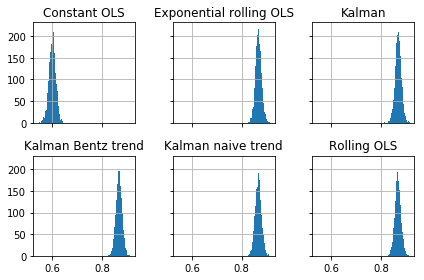

In [387]:
performance_record_wacc.hist(layout=(2, 3), bins=50, sharex=True, sharey=True)
plt.tight_layout()

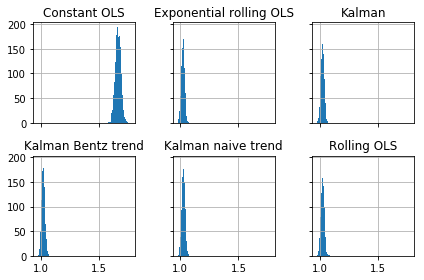

In [388]:
performance_record_mse.hist(layout=(2, 3), bins=50, sharex=True, sharey=True)
plt.tight_layout()

In [389]:
import pickle
with open('20190312-wERR-performance_record.pickle', 'wb') as f:
    pickle.dump({"Weighted accuracy": performance_record_wacc, "MSE": performance_record_mse}, f)

In [1264]:
with open('performance_record.pickle', 'rb') as f:
    ls = pickle.load(f)
ls

{'MSE':       Constant OLS    Kalman  Kalman Bentz trend  Kalman naive trend  \
 0         1.642084  0.959128            0.969325            0.934450   
 1         1.652597  0.953329            0.964440            0.928491   
 2         1.672936  0.956445            0.966112            0.932220   
 3         1.673412  0.957570            0.967425            0.932708   
 4         1.673309  0.965016            0.974735            0.940621   
 5         1.683193  0.963870            0.972889            0.940625   
 6         1.654992  0.967241            0.977574            0.942468   
 7         1.658842  0.940273            0.949614            0.916005   
 8         1.660779  0.952864            0.963289            0.928959   
 9         1.661458  0.964175            0.974029            0.939953   
 10        1.666550  0.978255            0.987707            0.952743   
 11        1.682632  0.947483            0.958717            0.923289   
 12        1.645867  0.966099            0.9

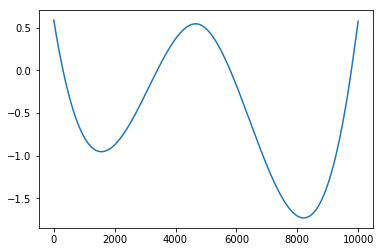

In [747]:
random_sensitivity = create_random_sensitivity(timespan)
#values = splev(factors.index, random_sensitivity)

plt.figure()
random_sensitivity.plot()
#plt.plot(factors.index, values)
plt.show()